<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Phase2/Session5/EVAP2S5_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10, 10), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


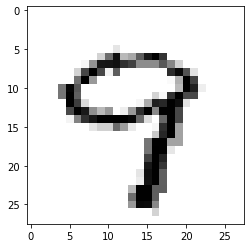

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
'''
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))
'''
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

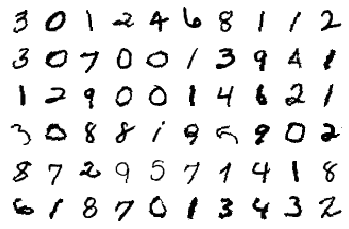

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
           Dropout-3           [-1, 32, 26, 26]               0
            Conv2d-4           [-1, 64, 24, 24]          18,432
              ReLU-5           [-1, 64, 24, 24]               0
           Dropout-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 22, 22]          73,728
              ReLU-8          [-1, 128, 22, 22]               0
           Dropout-9          [-1, 128, 22, 22]               0
        MaxPool2d-10          [-1, 128, 11, 11]               0
           Conv2d-11           [-1, 32, 11, 11]           4,096
      BatchNorm2d-12           [-1, 32, 11, 11]              64
             ReLU-13           [-1, 32, 11, 11]               0
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07420716434717178 Batch_id=468 Accuracy=93.67: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
Loss=0.023525215685367584 Batch_id=4 Accuracy=97.50:   1%|          | 3/469 [00:00<00:17, 26.43it/s]


Test set: Average loss: 0.0433, Accuracy: 9855/10000 (98.55%)

EPOCH: 1


Loss=0.0802241787314415 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
Loss=0.051377832889556885 Batch_id=4 Accuracy=99.06:   1%|          | 3/469 [00:00<00:16, 28.45it/s]


Test set: Average loss: 0.0303, Accuracy: 9897/10000 (98.97%)

EPOCH: 2


Loss=0.04552416130900383 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]
Loss=0.04639628157019615 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<00:17, 26.75it/s] 


Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)

EPOCH: 3


Loss=0.05011909082531929 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]
Loss=0.06396709382534027 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<00:15, 29.40it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH: 4


Loss=0.07312405854463577 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]
Loss=0.01540350541472435 Batch_id=4 Accuracy=99.38:   1%|          | 3/469 [00:00<00:16, 28.71it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.01080698799341917 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
Loss=0.013341933488845825 Batch_id=4 Accuracy=99.06:   1%|          | 3/469 [00:00<00:17, 27.24it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.021739086136221886 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]
Loss=0.0177987739443779 Batch_id=4 Accuracy=98.44:   1%|          | 3/469 [00:00<00:17, 26.89it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 7


Loss=0.047920092940330505 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]
Loss=0.030381783843040466 Batch_id=4 Accuracy=99.38:   1%|          | 3/469 [00:00<00:16, 28.36it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


Loss=0.07135609537363052 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 26.49it/s]
Loss=0.058110229671001434 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<00:17, 26.05it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.05051463842391968 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
Loss=0.02312341518700123 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<00:16, 29.12it/s] 


Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.04687260463833809 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]
Loss=0.033927612006664276 Batch_id=4 Accuracy=98.91:   1%|          | 3/469 [00:00<00:18, 24.92it/s]


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)

EPOCH: 11


Loss=0.045281220227479935 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
Loss=0.016504283994436264 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<00:18, 25.73it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.01190893817692995 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]
Loss=0.0032779909670352936 Batch_id=4 Accuracy=99.53:   1%|          | 3/469 [00:00<00:17, 27.22it/s]


Test set: Average loss: 0.0152, Accuracy: 9958/10000 (99.58%)

EPOCH: 13


Loss=0.01331766415387392 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]
Loss=0.0481729619204998 Batch_id=4 Accuracy=98.91:   1%|          | 3/469 [00:00<00:17, 26.52it/s] 


Test set: Average loss: 0.0163, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.003636469366028905 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
Loss=0.026994936168193817 Batch_id=4 Accuracy=99.53:   1%|          | 3/469 [00:00<00:16, 28.43it/s]


Test set: Average loss: 0.0151, Accuracy: 9951/10000 (99.51%)

EPOCH: 15


Loss=0.0008477370138280094 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
Loss=0.01974739134311676 Batch_id=4 Accuracy=98.91:   1%|          | 3/469 [00:00<00:15, 29.79it/s] 


Test set: Average loss: 0.0153, Accuracy: 9949/10000 (99.49%)

EPOCH: 16


Loss=0.019283562898635864 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]
Loss=0.004516705870628357 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<00:16, 28.92it/s]


Test set: Average loss: 0.0159, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.043350815773010254 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]
Loss=0.0007200241088867188 Batch_id=3 Accuracy=99.22:   1%|          | 3/469 [00:00<00:19, 24.24it/s]


Test set: Average loss: 0.0150, Accuracy: 9957/10000 (99.57%)

EPOCH: 18


Loss=0.015419244766235352 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
Loss=0.01552773080766201 Batch_id=4 Accuracy=99.69:   1%|          | 3/469 [00:00<00:16, 28.86it/s] 


Test set: Average loss: 0.0147, Accuracy: 9955/10000 (99.55%)

EPOCH: 19


Loss=0.0037527878303080797 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0156, Accuracy: 9952/10000 (99.52%)



Text(0.5, 1.0, 'Test Accuracy')

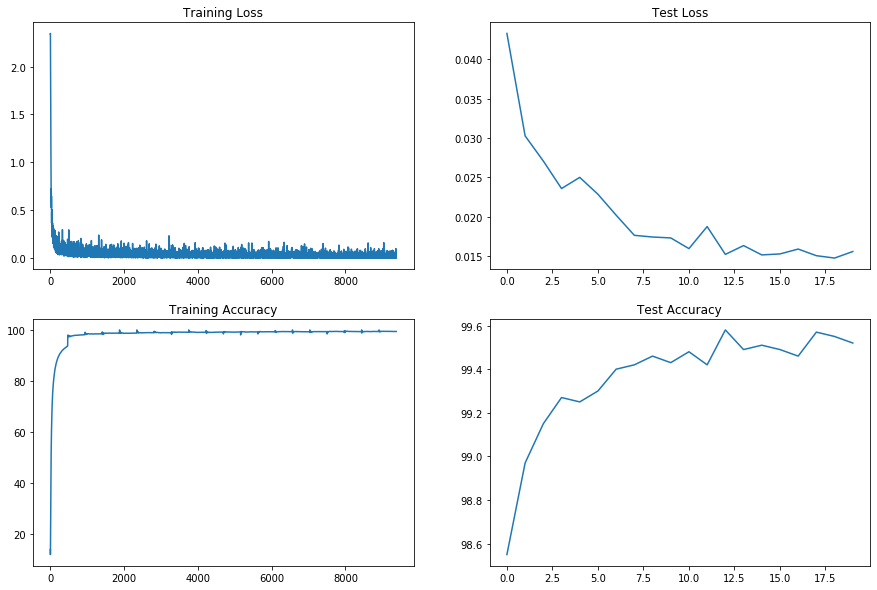

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")